# Lab Course Machine Learning
### Exercise Sheet 8
Prof. Dr. Dr. Lars Schmidt-Thieme, Hadi Samer Jomaa
Information Systems and Machine Learning Lab
University of Hildesheim
December 18th, 2017
Submission on December 25th, 2017 at 8:00 am, (on moodle, course code 3113)

#### Datasets
1. Classification Datasets: You can use one of the two datasets ( or optionally, both datasets).

    (a) Car Evaluation dataset D1: Target attribute safety:{low, med, high}. https://archive.ics.uci.edu/ml/datasets/Car+Evaluation 

    (b) Iris dataset D2 : Target attribute class:{Iris Setosa, Iris Versicolour, Iris Virginica}. https://archive.ics.uci.edu/ml/datasets/Iris

## Exercise 1: Implement Decision Tree (12 Points)
Objetive: Implement Learn-Decision-Tree with an appropriate Quality-criterion and Predict-Decision-Tree

### Part A: (8 Points) Basic working and Cross Entropy
    A) Split data into train and test (70% and 30% respectively). 
    B) Using the train data you will build a decision tree. 
    C) Use Cross Entropy as a Quality-criterion. 

You have to provide information on the learning process that includes:
1. Define an appropriate stopping criteria i.e. max depth, gain is too small or reduction in cost is small
    ###### Max deph and Information Gain >0 used

   
2. At each decision step (or split) present the probability of each class using histogram (properly labeled figure)
3. At each decision step, plot the Cross Entropy of each attribute.
4. Note down the Information Gain at each new node created, you can store it in node structure or class. Display it at the end. 
5. Print your tree using a breath first tree traversal. (you can also print node hierarchical level, information gain and decision rule, etc) 
6. On a test set measure the cross entropy loss (i.e. logloss, note that this time problem is not binary classification).



### Part B: (4 Points) Experiment with other Quality-criterion 
Objetive: Gini Index and Gini Gain as a Quality-criterion and compare it with Cross Entropy

    1. Use the train and test split from Part A and implementation of Decision tree as well.
    2. modify the Quality-criterion to Gini Index.
    3. At each decision step, plot the Gini Index and Cross Entropy of each attribute. 
    [Hint: reuse Cross Entropy values from Part A]
    4. At each decision step, plot the Information Gain of each new node created.
    5. On a test set measure the cross entropy loss. Compare the test results for both Quality-criterion



In [131]:
import operator
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CarsT = ["Buying","Maint","Doors","Persons","Lug_boot","Safety","Acceptance"]
IrisT = ["Sepal L","Sepal W","Petal L", "Petal W", "Flower_t"]
Iris = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",names = IrisT)
Cars = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",names = CarsT)

In [4]:
Iris.head()

,Sepal L,Sepal W,Petal L,Petal W,Flower_t
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
Cars.head()

,Buying,Maint,Doors,Persons,Lug_boot,Safety,Acceptance
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [310]:
#Transforming the Data Frames into Arrays

#For Cars, a re-odering is needed to allocate the Safety column to the end, as classification objetive
Cols = ["Buying","Maint","Doors","Persons","Lug_boot","Acceptance","Safety"]
Cars = Cars[Cols]

#Train and Test sepparating function

def split(Dataframe,P): 
    #Defining the split, the objetive data is kept in the same matrix, at the end (the "-1" values)           
    Data = np.array(Dataframe)                        
    msk = np.random.rand(len(Data)) < P                         
    tr = Data[msk]
    tst = Data[~msk]    
    return tr, tst 

#Iris
Itr, Itst = split(Iris,0.70)

#Cars
Ctr, Ctst = split(Cars,0.70)

In [105]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

def class_counts(rows):
    #Counts the number of each type of example in a dataset
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

def is_numeric(value):
    #Test if a value is numeric
    return isinstance(value, int) or isinstance(value, float)

class SplitCriteria:
    #A SplitCriteria is used to partition a dataset.

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this split_criteria.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print the split_criteria in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Criteria %s %s %s:" % (
            header[self.column], condition, str(self.value))

def partition(rows, split_criteria):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the split_criteria. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if split_criteria.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

def Gini(rows):
    #Calculate the Gini Impurity for a list of rows.
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

def Entropy(rows):
    #Calculate Entropy for a list of rows
    counts = class_counts(rows)
    Entropy = 0
    for lbl in counts:
        if lbl ==0:
            0
        else:
            prob_of_lbl = counts[lbl] / float(len(rows))
            Entropy += math.log(1/prob_of_lbl,2)*prob_of_lbl 
    return Entropy

def info_gain(left, right, current_uncertainty, CostF):
    #Information Gain.
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - (p * CostF(left) + (1 - p) * CostF(right))

In [92]:
#Example of Gini Impurity for Iris dataset
print(class_counts(Itr))
print("Gini", Gini(Itr))


{'Iris-setosa': 32, 'Iris-versicolor': 31, 'Iris-virginica': 29}
Gini 0.6661153119092627


In [93]:
#Example of Entropy for Cars dataset
print(class_counts(Ctr))
print("Entropy",Entropy(Ctr))

{'low': 419, 'med': 392, 'high': 403}
Entropy 1.584422167450113


In [306]:
def find_best_split(rows, CostF):
    """Find the best split_criteria to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_split_criteria = None  # keep train of the feature / value that produced it
    current_uncertainty = CostF(rows)
    n_features = len(rows[0]) - 1                 # number of columns

    for col in range(n_features):                 # for each feature
        values = set([row[col] for row in rows])  # unique values in the column
        for val in values:                        # for each value
            split_criteria = SplitCriteria(col, val)
            # try splitting the dataset
            true_rows, false_rows = partition(rows, split_criteria)
            # Skip this split if it doesn't divide the dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty,CostF)
            #print(header[col],val,"IG ", gain)  #Will print all the posible gains, deactived in main program
            
            if gain >= best_gain:
                best_gain, best_split_criteria = gain, split_criteria
    return best_gain, best_split_criteria

In [304]:
#Example of finding the best split, the program check value of each column and calculates the best criteria

#Cars Data Set

header = Cols
find_best_split(Ctr,Entropy)

Buying low IG  0.044380708730545004
Buying med IG  0.00823224543925516
Buying vhigh IG  0.0446503089456165
Buying high IG  0.032614809194358774
Maint low IG  0.04552690310965701
Maint med IG  0.004165149518586597
Maint vhigh IG  0.04636452315267703
Maint high IG  0.01854255058530785
Doors 3 IG  0.0010884794038983348
Doors 4 IG  0.0011320865310773254
Doors 2 IG  0.004267242105667979
Doors 5more IG  0.0022525277760856444
Persons 4 IG  0.041373247020261905
Persons 2 IG  0.22578068360704617
Persons more IG  0.03707385921391215
Lug_boot small IG  0.028529142890777015
Lug_boot big IG  0.013751949750084647
Lug_boot med IG  0.0011576664277501703
Safety low IG  0.2235442110249558
Safety med IG  0.04360230132025844
Safety high IG  0.11501120168624124


(0.22578068360704617, Criteria Persons == 2:)

In [95]:
#Example of finding the best split, the program check value of each column and calculates the best criteria
#If a tie, the first one will be choosen

#Iris Data Set

header = IrisT
find_best_split(Itr,Gini)

Sepal L 4.4 IG  0.00701354411184274
Sepal L 4.8 IG  0.06920593527228003
Sepal L 4.7 IG  0.05256032469698646
Sepal L 5.1 IG  0.14045780900966698
Sepal L 4.6 IG  0.021513455534079573
Sepal L 5.8 IG  0.19352551984877106
Sepal L 5.7 IG  0.19884942562163715
Sepal L 5.0 IG  0.10037091138225337
Sepal L 5.2 IG  0.2226167814542104
Sepal L 5.4 IG  0.2353664006506062
Sepal L 7.0 IG  0.04564429741650888
Sepal L 7.3 IG  0.03197499570372908
Sepal L 4.9 IG  0.10502560359886093
Sepal L 5.6 IG  0.24342815924499325
Sepal L 5.9 IG  0.17940962629053359
Sepal L 5.5 IG  0.249308392788178
Sepal L 6.1 IG  0.1614632261874177
Sepal L 6.4 IG  0.133303920402219
Sepal L 6.0 IG  0.16890347556699148
Sepal L 6.6 IG  0.07057411854198237
Sepal L 6.5 IG  0.09769026889756938
Sepal L 7.9 IG  0.007730218741560879
Sepal L 6.7 IG  0.07556117721190536
Sepal L 6.3 IG  0.15039698059872741
Sepal L 6.2 IG  0.15718284001723404
Sepal L 6.8 IG  0.0633051316335469
Sepal L 7.2 IG  0.057931168686756296
Sepal L 7.7 IG  0.023711794566810

(0.3403906742281032, Criteria Petal W >= 1.0:)

In [277]:
class Leaf:
    #A Leaf node classifies data.

    def __init__(self, rows):
        self.predictions = class_counts(rows)

def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs
        
class Decision_Node:
    #A Decision Node asks a split_criteria.
    def __init__(self,
                 split_criteria,
                 true_branch,
                 false_branch,
                 gain):
        self.split_criteria = split_criteria
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.gain = gain

def build_tree(rows,CostF,maxdepth,depth):
    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain and return the split_criteria that produces the highest gain.
    gain, split_criteria = find_best_split(rows,CostF)

    # Case: no further info gain
    # Since we can ask no further split_criterias,we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    #Case: Max depth reached, return a leaf
    if depth >= maxdepth:
        return Leaf(rows)
    
    # Found a useful feature / value to partition on.
    true_rows, false_rows = partition(rows, split_criteria)
    depth += 1

    # Recursively build the true branch.
    true_branch = build_tree(true_rows,CostF,maxdepth,depth)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows,CostF,maxdepth,depth)

    # Return a SplitCriteria node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow dependingo on the answer.
    return Decision_Node(split_criteria, true_branch, false_branch, gain)

def print_tree(node, spacing=""):
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Class Content in Node", print_leaf(node.predictions))
        print (spacing + "Class majority", max(node.predictions.items(), key=operator.itemgetter(1))[0])
        return

    # Print the split_criteria at this node
    print (spacing + str(node.split_criteria) + str(" Info Gain ") + str(node.gain))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [351]:
training_data = Ctr
header = Cols

my_tree = build_tree(training_data,Entropy,50,0)
print_tree(my_tree)

Criteria Acceptance == unacc: Info Gain 0.22851503626850955
--> True:
  Criteria Persons == 2: Info Gain 0.06419958925756752
  --> True:
    Criteria Maint == vhigh: Info Gain 0.0030076547530168973
    --> True:
      Criteria Lug_boot == big: Info Gain 0.01321068829226446
      --> True:
        Criteria Buying == low: Info Gain 0.048108386046948226
        --> True:
          Criteria Doors == 4: Info Gain 0.12255624891826566
          --> True:
            Class Content in Node {'low': '50%', 'med': '50%'}
            Class majority low
          --> False:
            Class Content in Node {'low': '33%', 'med': '33%', 'high': '33%'}
            Class majority low
        --> False:
          Criteria Doors == 4: Info Gain 0.06909768667710336
          --> True:
            Class Content in Node {'low': '50%', 'high': '50%'}
            Class majority low
          --> False:
            Criteria Buying == high: Info Gain 0.04906204601622255
            --> True:
              Crite

                        --> False:
                          Class Content in Node {'low': '50%', 'med': '50%'}
                          Class majority low
                    --> False:
                      Criteria Doors == 5more: Info Gain 0.17095059445466876
                      --> True:
                        Class Content in Node {'low': '33%', 'med': '33%', 'high': '33%'}
                        Class majority low
                      --> False:
                        Class Content in Node {'low': '50%', 'high': '50%'}
                        Class majority low
                --> False:
                  Criteria Doors == 5more: Info Gain 0.04995021505006192
                  --> True:
                    Criteria Maint == high: Info Gain 0.11007306515453119
                    --> True:
                      Criteria Buying == vhigh: Info Gain 0.2516291673878229
                      --> True:
                        Class Content in Node {'med': '50%', 'high': '50%'}
 

In [341]:
training_data = Irs
header = IrisT

my_tree = build_tree(training_data,Entropy,7,0)

print_tree(my_tree)

Criteria Petal W >= 1.0: Info Gain 0.9182958340544894
--> True:
  Criteria Petal W >= 1.8: Info Gain 0.6901603707546748
  --> True:
    Criteria Petal L >= 4.9: Info Gain 0.09120811177442953
    --> True:
      Class Content in Node {'Iris-virginica': '100%'}
      Class majority Iris-virginica
    --> False:
      Criteria Sepal W >= 3.2: Info Gain 0.9182958340544896
      --> True:
        Class Content in Node {'Iris-versicolor': '100%'}
        Class majority Iris-versicolor
      --> False:
        Class Content in Node {'Iris-virginica': '100%'}
        Class majority Iris-virginica
  --> False:
    Criteria Petal L >= 5.0: Info Gain 0.21317043093799617
    --> True:
      Criteria Petal W >= 1.6: Info Gain 0.4591479170272448
      --> True:
        Criteria Petal L >= 5.8: Info Gain 0.9182958340544896
        --> True:
          Class Content in Node {'Iris-virginica': '100%'}
          Class majority Iris-virginica
        --> False:
          Class Content in Node {'Iris-versi

In [335]:
#Making Predictions

def classify(row, node):
    
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        #return print_leaf(node.predictions)        #To show p-values of resulting desition node, deactived in main program
        return max(node.predictions.items(), key=operator.itemgetter(1))[0] #The most likely prediction for that row

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.split_criteria.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)


In [362]:
def Predict_fit(TestData, Fit):
    n = 0                     #To store the correct predictions
    lg = 0                    #To store the logloss
    for row in TestData:
        if classify(row,Fit) == row[-1]:
            n += 1
        #print ("Actual: %s. Predicted: %s" % #To show each prediction per row, deactived in main program
         #  (row[-1],classify(row, Fit)))
    Acc = n/len(TestData)*100
    #print ("Accuracy",Acc)                          #To show Accuracy metric, deactived on main program
    #print ("Missclasification", 1- n/len(TestData)) #To show Missclasification metric, deactived on main program
    return 1- n/len(TestData) #Misclassification 

    

In [328]:
#Example of prediction on test set for car data
#Algorithm modified to show the p-value of the resulting desition-node (if not pure, 2 or more p-values showed)
#The prediction in such case will be the majority class, if a tie, the firs one.

Predict_fit(Ctst,my_tree)

Actual: high. Predicted: {'low': '50%', 'med': '50%'}
Actual: med. Predicted: {'low': '50%', 'high': '50%'}
Actual: low. Predicted: {'high': '100%'}
Actual: med. Predicted: {'high': '100%'}
Actual: med. Predicted: {'low': '100%'}
Actual: high. Predicted: {'low': '100%'}
Actual: med. Predicted: {'low': '50%', 'high': '50%'}
Actual: med. Predicted: {'low': '100%'}
Actual: high. Predicted: {'low': '100%'}
Actual: med. Predicted: {'low': '66%', 'high': '33%'}
Actual: high. Predicted: {'low': '66%', 'high': '33%'}
Actual: med. Predicted: {'low': '50%', 'high': '50%'}
Actual: low. Predicted: {'med': '66%', 'high': '33%'}
Actual: high. Predicted: {'med': '66%', 'high': '33%'}
Actual: med. Predicted: {'low': '100%'}
Actual: high. Predicted: {'low': '100%'}
Actual: high. Predicted: {'low': '50%', 'med': '50%'}
Actual: med. Predicted: {'low': '50%', 'high': '50%'}
Actual: med. Predicted: {'low': '50%', 'high': '50%'}
Actual: med. Predicted: {'low': '50%', 'high': '50%'}
Actual: med. Predicted: {

0.0

In [331]:
#Same example only with the prediction of that node

Predict_fit(Ctst,my_tree)

Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: low. Predicted: high
Actual: med. Predicted: high
Actual: med. Predicted: low
Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: med. Predicted: low
Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: low. Predicted: med
Actual: high. Predicted: med
Actual: med. Predicted: low
Actual: high. Predicted: low
Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: med. Predicted: low
Actual: med. Predicted: low
Actual: med. Predicted: low
Actual: low. Predicted: high
Actual: med. Predicted: high
Actual: low. Predicted: high
Actual: med. Predicted: high
Actual: med. Predicted: low
Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: high. Predicted: low
Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: high. Predicted: low
Actual: med. Predicted: low
Actual: low. Predicted: med
Actual: high. Predicted: low
Ac

('Accuracy', 34.146341463414636)

In [352]:
#Same example, with only the accuracy metrics. It behaves better on training data than in test data
#It is overfitted; performance is 50% lower on test data
#Car data set, full tree 

print("Iris Trainig Data Set")

Predict_fit(Ctr,my_tree)

print("Iris Testing Data Set")
Predict_fit(Ctst,my_tree)

Iris Trainig Data Set
Accuracy 64.64401294498381
Missclasification 0.3535598705501618
Iris Testing Data Set
Accuracy 34.146341463414636
Missclasification 0.6585365853658536


In [350]:
#Iris Data set, full tree, it perfectly predict on both, Test and Training Data

print("Iris Trainig Data Set")

Predict_fit(Itr,my_tree)

print("Iris Testing Data Set")
Predict_fit(Itst,my_tree)


Iris Trainig Data Set
Accuracy 100.0
Missclasification 0.0
Iris Testing Data Set
Accuracy 100.0
Missclasification 0.0


## Exercise 2: Pruning The Decision Tree (8 Points)

The complexity of a decision tree depends on the height/depth of the tree. It also influence the overfitting or under-fitting behavior. Generally, two rules are used to restrict the height/depth of a decision tree, i.e. pre-pruning and post-pruning. In pre-pruning an early stopping criteria is used while in post- pruning a validation dataset is used (through cross validation) to prune the tree. 

• Objetive: Implement post-pruning technique known as Reduced Error Pruning:

    • Create a validation protocol i.e. split data into three splits, i.e. Train(34%), Validation(33%) and Test(33%)
    • Build the decision tree (using implementation from Exercise 1)

In particular you have to show during pruning process:

    • You have to show for each pruning decision the gain at the parent node and collective gain of the children of 
    that particular node. (Showing stats for the case at which pruning happens is enough.)
    •Using the test set measure the cross entropy loss (i.e. logloss). 

Did you see any gain in test results over results in Exercise 1?


In [373]:
Depth = np.arange(0,50)

#IrisData Set

header = IrisT

def Pruning(Data,CostF,Depth):
    Train, to_split = split(Data,0.34)
    Validation, Test = split(to_split,0.5)
    
    node = []
    error_v = [] #Store nodes vs Error on validation data
    error_t = [] #Store nodes vs Error on test data
    error_train = [] #Store node vs Error on train data
    best_node = 0  #Keeping track of best node and min error
    min_error = 1  
    
    for value in Depth:
        Tree_Model = build_tree(Train,CostF,value,0)
        etr = Predict_fit(Train,Tree_Model)
        error_train.append(etr)
        ev = Predict_fit(Validation,Tree_Model)
        error_v.append(ev)
        et = Predict_fit(Test,Tree_Model)
        error_t.append(et)
        node.append(value)
        
        if ev< min_error:
            min_error = ev
            best_node = value

    plt.plot(node,error_v)
    plt.plot(node,error_t)
    plt.plot(node,error_train)
    plt.title("Pruning, Error vs Tree Depth")
    plt.xlabel("Depth")    
    plt.ylabel("Missclasification")
    plt.legend(["Validation","Test","Train"])
    plt.show()
    return ("Best values, Node:",best_node,"Min error on Validation", min_error)

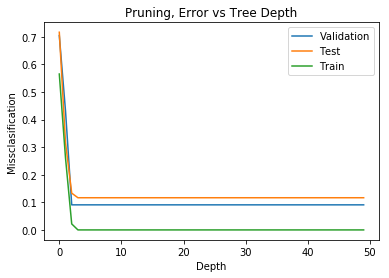

('Best values, Node:', 2, 'Min error on Validation', 0.09090909090909094)

In [374]:
#Pruning the Iris Data Set
Pruning(Iris,Gini,Depth)

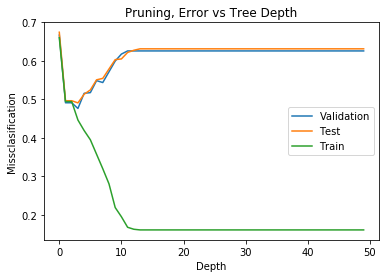

('Best values, Node:', 3, 'Min error on Validation', 0.47619047619047616)

In [377]:
#In this case is very notorious the effect of overfitting on the validation and test data

header = Cols
Pruning(Cars,Gini,Depth)